In [3]:
import pandas as pd
from data_utils import ts_data_formulator, splitter, seed_all, normalize
import numpy as np

bike_data = pd.read_csv("Dataset/Bike-Sharing-Dataset/hour.csv", index_col = "instant")

bike_data_indep = bike_data.iloc[:, 2:13]

bike_data_dep = bike_data.iloc[:, 15:]

x = bike_data_indep.to_numpy()
y = bike_data_dep.to_numpy()

SEED = 1234

seed_all(SEED)

x_normed, x_normalizer = normalize(x)

x = x_normed

N_train = int(len(x) * 0.9)
N_test = int(len(x) * 0.1)

tr_idx = np.arange(len(x))[:N_train]

te_idx = np.arange(len(x))[N_train:N_train+N_test]


test_X, test_Y = ts_data_formulator(x[te_idx], y[te_idx])

test_Y = np.squeeze(test_Y, axis = 1)


x_reshaped, y_reshaped = ts_data_formulator(x[tr_idx], y[tr_idx])


N_model_train = int(len(y_reshaped) * 0.7)
N_recalibration = int(len(y_reshaped) * 0.3)

tr_new_idx, recal_idx = splitter(N_model_train, N_recalibration, seed = SEED)


recal_X = x_reshaped[recal_idx]
recal_Y = np.squeeze(y_reshaped[recal_idx], axis = 1)



x_remain, y_remain = x_reshaped[tr_new_idx], y_reshaped[tr_new_idx]


split = 0.8
train_idx, val_idx = splitter(int(split * len(y_remain)), len(y_remain) - int(split * len(y_remain)), seed = SEED)


train_X, train_Y = x_remain[train_idx], y_remain[train_idx]
val_X, val_Y = x_remain[val_idx], y_remain[val_idx]


## LSTM heteroskedastic

In [30]:
from src.LSTMmodels import Vanilla_LSTM
from src.losses import mse_loss, rmse_loss, mean_std_norm_loss
import torch



seed_all(SEED)
n_feature = x.shape[1]

epochs = 300

COV_DIM = train_X.shape[2]
LSTM_HIDDEN_DIM = 40

train_X = torch.Tensor(train_X)
train_Y = torch.Tensor(train_Y).view(-1).cuda()
val_X = torch.Tensor(val_X)
val_Y = torch.Tensor(val_Y).view(-1).cuda()





nll_model = Vanilla_LSTM(
    COV_DIM = COV_DIM,
    LSTM_HIDDEN_DIM = LSTM_HIDDEN_DIM,
    LSTM_LAYER = 2,
)

nll_model.train(
    train_X, train_Y, val_X, val_Y.view(-1),
    LR = 1E-2,
    N_Epoch = epochs,
    
    loss_criteria =  mean_std_norm_loss,
    val_loss_criterias = {
        "rmse": rmse_loss
    },
    
    early_stopping = True,
    patience = 50
)


torch.save(nll_model.state_dict(), "Experiments/EXP2/model_bin/TS_LSTM.pth")

epoch  0
     loss: rmse, 238.22201538085938
epoch  15
     loss: rmse, 181.97813415527344
epoch  30
     loss: rmse, 171.88241577148438
epoch  45
     loss: rmse, 170.5846405029297
epoch  60
     loss: rmse, 170.16261291503906
epoch  75
     loss: rmse, 164.83641052246094
epoch  90
     loss: rmse, 159.67564392089844
epoch  105
     loss: rmse, 152.4290771484375
epoch  120
     loss: rmse, 117.0268783569336
epoch  135
     loss: rmse, 99.5239486694336
epoch  150
     loss: rmse, 73.83917999267578
epoch  165
     loss: rmse, 60.81785583496094
epoch  180
     loss: rmse, 54.97504806518555
epoch  195
     loss: rmse, 52.164283752441406
epoch  210
     loss: rmse, 51.170928955078125
epoch  225
     loss: rmse, 49.8984260559082
Early Stopped at Epoch  232


In [31]:
from src.losses import rmse_loss, mean_std_norm_loss

test_X = torch.Tensor(test_X).cuda()
test_Y = torch.Tensor(test_Y).view(-1).cuda()

te_err = rmse_loss(nll_model.predict(test_X), test_Y)

print("RMSE error: ", te_err.item())

RMSE error:  91.66258239746094


C:\Users\16065\AppData\Local\Temp\ipykernel_2340\3726585475.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


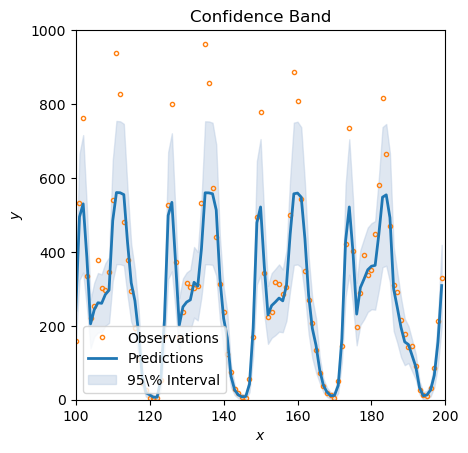

In [70]:
import matplotlib.pyplot as plt
from src.DEFAULTS import normalZ
from src.plot_utils import plot_xy_specifyBound

fig, ax = plt.subplots()

ylims = [0, 1000]


sample_start = 100
sample_end = 200


preds = nll_model.predict(test_X[sample_start:sample_end]).detach().cpu().numpy()

pred_mean = preds[:,0]
pred_sig = preds[:,1]

y_test_UP = pred_mean + normalZ.ppf(0.975) * pred_sig
y_test_LO = pred_mean + normalZ.ppf(0.025) * pred_sig



# Make xy plot
axs = plot_xy_specifyBound(
    pred_mean, y_test_UP, y_test_LO, test_Y.cpu().numpy()[sample_start:sample_end], np.arange(sample_start, sample_end), n_subset = None, ylims=ylims, xlims=[sample_start, sample_end], ax=ax
)

fig.show()

# LSTM with kernel and random projection

In [37]:
mse_model = Vanilla_LSTM(
    COV_DIM = COV_DIM,
    LSTM_HIDDEN_DIM = LSTM_HIDDEN_DIM,
    LSTM_LAYER = 2,
    output_scheme = "pred"
)

mse_model.train(
    train_X, train_Y, val_X, val_Y,
    LR = 5E-3,
    N_Epoch = epochs,
    
    early_stopping = True,
    patience = 30
)

torch.save(mse_model.state_dict(), "Experiments/EXP2/model_bin/TS_LSTM_pred.pth")

epoch  0
     loss: rmse, 225.57171630859375
epoch  15
     loss: rmse, 98.5696792602539
epoch  30
     loss: rmse, 61.924560546875
epoch  45
     loss: rmse, 49.20547103881836
epoch  60
     loss: rmse, 40.87557601928711
epoch  75
     loss: rmse, 38.51313018798828
epoch  90
     loss: rmse, 40.0315055847168
Early Stopped at Epoch  105


In [38]:
mse_te_err = rmse_loss(mse_model.predict(test_X), test_Y)

print("RMSE error: ", mse_te_err.item())

RMSE error:  83.84405517578125


C:\Users\16065\AppData\Local\Temp\ipykernel_2340\252673947.py:52: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


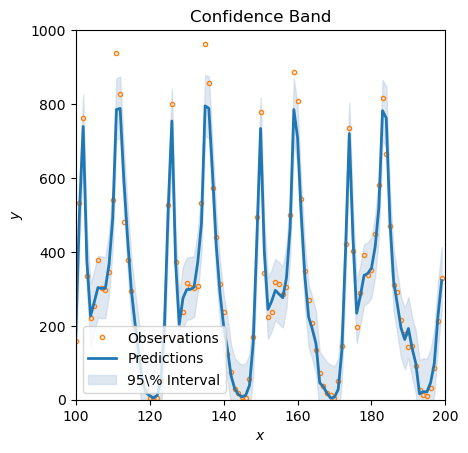

In [69]:
from sklearn import random_projection
from src.kernel_methods import kernel_estimator


recal_X = torch.Tensor(recal_X).cuda()
recal_Y = torch.Tensor(recal_Y).view(-1).cuda()


fig, ax = plt.subplots()

ylims = [0, 1000]

sample_start = 100
sample_end = 200

sub_testX = test_X[sample_start:sample_end]

n_component = 4
wid = 10

transformer = random_projection.GaussianRandomProjection(n_components = n_component)

reformer = lambda x : torch.Tensor(transformer.fit_transform(x.cpu().numpy()))

recal_mean = mse_model.predict(recal_X).view(-1)
test_mean = mse_model.predict(sub_testX).view(-1)

test_Z =  reformer(sub_testX.reshape(len(sub_testX), -1))
recal_Z = reformer(recal_X.reshape(len(recal_X), -1))


eps_diffQuants = kernel_estimator(
    test_Z = test_Z.cuda(),
    recal_Z = recal_Z.cuda(),
    recal_epsilon = torch.Tensor(recal_Y - recal_mean).cuda(),
    quants = [0.025, 0.975],
    wid= wid
)

y_diffQuants = eps_diffQuants + test_mean.view(1,-1).repeat(len(eps_diffQuants),1)

y_test_UP = y_diffQuants[0].detach().cpu().numpy()
y_test_LO = y_diffQuants[1].detach().cpu().numpy()



# Make xy plot
axs = plot_xy_specifyBound(
    test_mean.detach().cpu().numpy(), y_test_UP, y_test_LO, test_Y[sample_start:sample_end].cpu().numpy(), np.arange(sample_start, sample_end), n_subset = None, ylims=ylims, xlims=[sample_start, sample_end], ax=ax
)

fig.show()

# If we don't random project

C:\Users\16065\AppData\Local\Temp\ipykernel_2340\3325862165.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


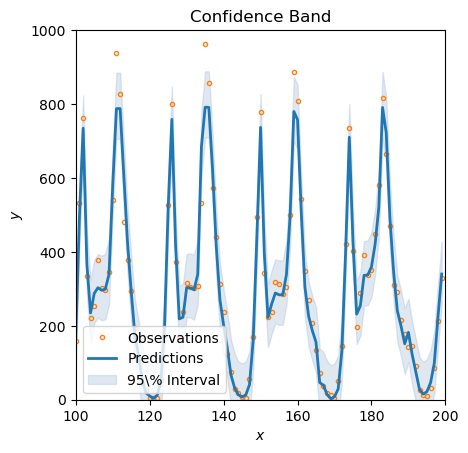

In [64]:
fig, ax = plt.subplots()

ylims = [0, 1000]

sample_start = 100
sample_end = 200

sub_testX = test_X[sample_start:sample_end]

wid = 10

recal_mean = mse_model.predict(recal_X).view(-1)
test_mean = mse_model.predict(sub_testX).view(-1)


eps_diffQuants = kernel_estimator(
    test_Z = sub_testX.reshape(len(sub_testX), -1).cuda(),
    recal_Z = recal_X.reshape(len(recal_X), -1).cuda(),
    recal_epsilon = torch.Tensor(recal_Y - recal_mean).cuda(),
    quants = [0.025, 0.975],
    wid= wid
)

y_diffQuants = eps_diffQuants + test_mean.view(1,-1).repeat(len(eps_diffQuants),1)

y_test_UP = y_diffQuants[0].detach().cpu().numpy()
y_test_LO = y_diffQuants[1].detach().cpu().numpy()



# Make xy plot
axs = plot_xy_specifyBound(
    test_mean.detach().cpu().numpy(), y_test_UP, y_test_LO, test_Y.cpu().numpy()[sample_start:sample_end], np.arange(sample_start, sample_end), n_subset = None, ylims=ylims, xlims=[sample_start, sample_end], ax=ax
)

fig.show()